In [440]:
using Revise
using EAMC
using Plots
using LinearAlgebra

# utility functions
linspace(x1, x2, n) = range(x1, stop=x2, length=n) |> collect
cg = cgrad(:matter, scale=:exp)
cg.colors[1] = colorant"white"
cg.values[2]=eps()
hm(x; kwargs...) = heatmap(x|>collect, yflip=true, color = cg; kwargs...)

hm (generic function with 1 method)

In [441]:
# experiment setup

beta = 5
phi = 1

nx = 20
xmax = 1.5

nt = 10
tmax = 10
ts = linspace(0, tmax, nt+1)

process = EAMC.OverdampedLangevin(
    V = (x,t) -> beta * (x^2-1)^2,
    phi = phi,
    grid = range(-xmax,xmax, length=nx))

qs = [EAMC.generatormatrix(process, t) for t in ts];

In [442]:
g = galerkin(qs, ts);

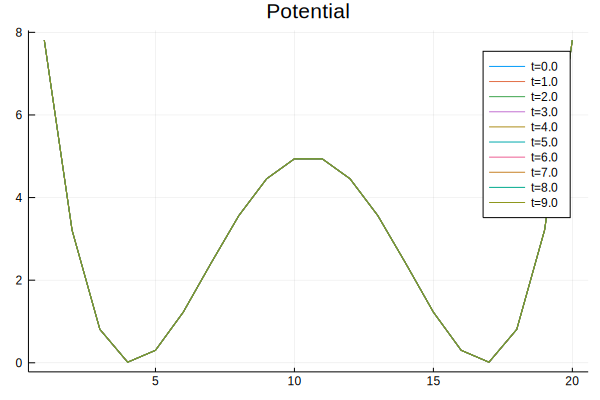

In [443]:
p=plot(title="Potential")
for t in ts[1:end-1]
    plot!(process.V.(process.grid,t),label="t=$(round(t, digits=2))")
end
p

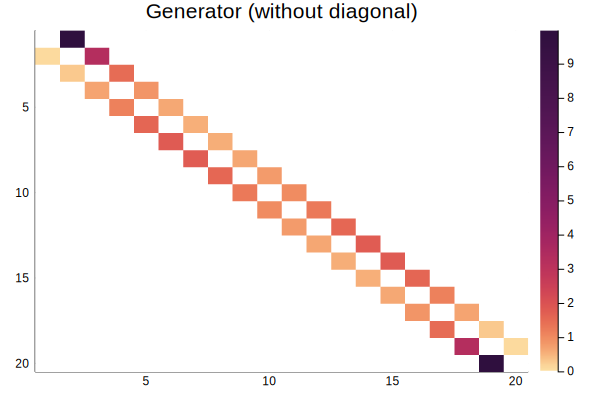

In [444]:
hm(qs[1]-Diagonal(qs[1]), title="Generator (without diagonal)")

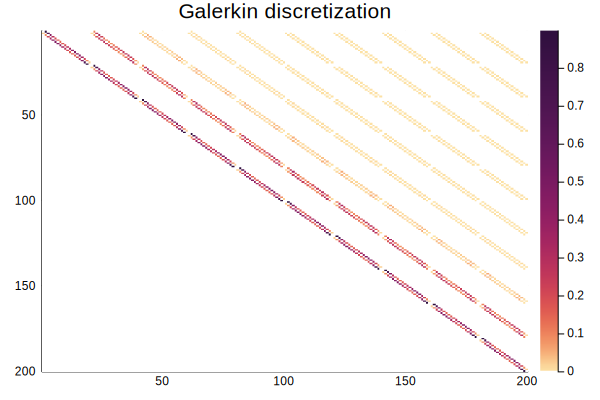

In [445]:
hm(g, color=cg, title="Galerkin discretization")

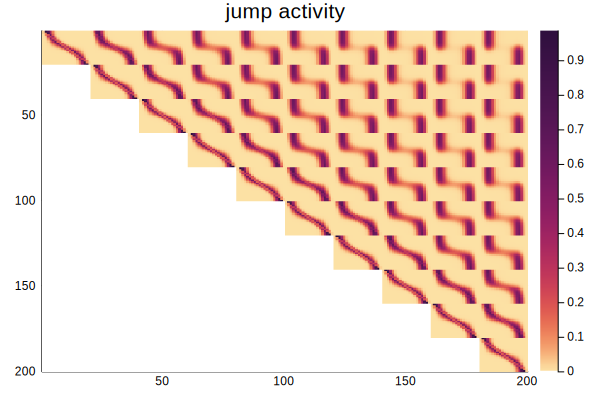

In [446]:
E = EAMC.jumpactivity(g)
hm(E, title="jump activity")

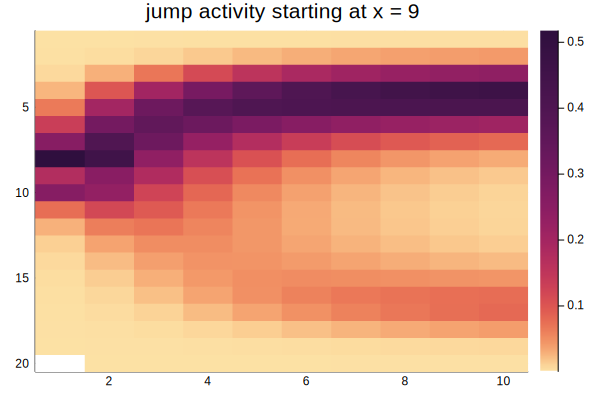

In [447]:
f0=zeros(nx)
x0 = 9
f0[x0] = 1
act = EAMC.project_jumpactivity(E, f0)
hm(act, title="jump activity starting at x = $x0")

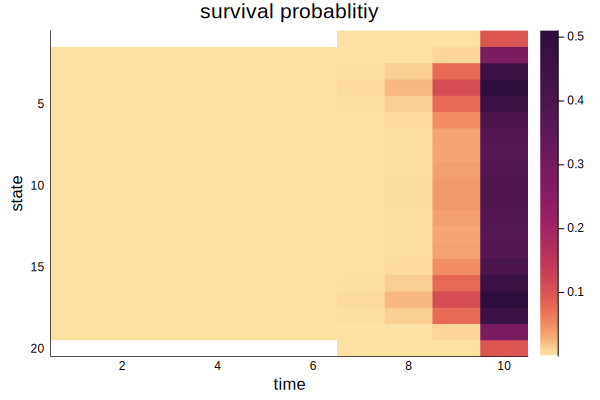

In [448]:
#survival from inside each timecell to T
qout = [collect(-diag(q)) for q in qs]
q = qout[1]
i = 4
S=zeros(nx, nt)
for i=1:nt
    S[:,i] .= 1 ./ q .*(exp.(-q*(ts[end] - ts[i+1])) - exp.(-q*(ts[end] - ts[i]))) / (ts[i+1]-ts[i])
end
hm(S, title="survival probablitiy", xlabel="time", ylabel="state")

In [449]:
# survival from 0 to T
fixture = Diagonal(exp.(-q*(ts[end] - ts[1])))

20×20 Diagonal{Float64,Array{Float64,1}}:
 4.24681e-44   ⋅            ⋅          …   ⋅            ⋅         
  ⋅           1.38738e-15   ⋅              ⋅            ⋅         
  ⋅            ⋅           1.69358e-8      ⋅            ⋅         
  ⋅            ⋅            ⋅              ⋅            ⋅         
  ⋅            ⋅            ⋅              ⋅            ⋅         
  ⋅            ⋅            ⋅          …   ⋅            ⋅         
  ⋅            ⋅            ⋅              ⋅            ⋅         
  ⋅            ⋅            ⋅              ⋅            ⋅         
  ⋅            ⋅            ⋅              ⋅            ⋅         
  ⋅            ⋅            ⋅              ⋅            ⋅         
  ⋅            ⋅            ⋅          …   ⋅            ⋅         
  ⋅            ⋅            ⋅              ⋅            ⋅         
  ⋅            ⋅            ⋅              ⋅            ⋅         
  ⋅            ⋅            ⋅              ⋅            ⋅         
  ⋅            ⋅    

In [450]:
Pf = EAMC.perronfrobenius(g, qs, ts)

20×20 Adjoint{Float64,Array{Float64,2}}:
 0.000154568  0.000154476  0.000154237  …  1.08664e-7   1.046e-7   
 0.0153943    0.0153865    0.0153662       1.19627e-5   1.1527e-5  
 0.169484     0.169416     0.169237        0.000153226  0.000147885
 0.374397     0.374302     0.374045        0.000435875  0.000421811
 0.279416     0.279408     0.279376        0.000510108  0.000495767
 0.109918     0.109955     0.110045     …  0.000429818  0.00042006 
 0.0328235    0.0328548    0.0329346       0.000385362  0.000378577
 0.00978963   0.00980909   0.00986007      0.000418136  0.000412392
 0.00344859   0.00346091   0.00349394      0.000543757  0.000537936
 0.00152112   0.00152974   0.00155336      0.000834369  0.000827651
 0.000827651  0.000834369  0.000853134  …  0.00152974   0.00152112 
 0.000537936  0.000543757  0.000560329     0.00346091   0.00344859 
 0.000412392  0.000418136  0.000434833     0.00980909   0.00978963 
 0.000378577  0.000385362  0.000405597     0.0328548    0.0328235  
 0.0004

In [451]:
Pf2 = exp(qs[1]|>collect)'

20×20 Adjoint{Float64,Array{Float64,2}}:
 0.00125215   0.000952592  0.000400579  …  1.25599e-18  4.77208e-19
 0.095007     0.0769985    0.0378154       3.20751e-16  1.25266e-16
 0.440632     0.417069     0.344679        1.94622e-14  7.89086e-15
 0.353643     0.375844     0.427911        4.54685e-13  1.9238e-13 
 0.0950529    0.110801     0.157593        5.67827e-12  2.51429e-12
 0.013057     0.0164827    0.027911     …  4.87632e-11  2.26336e-11
 0.00124432   0.0016894    0.00331821      3.49102e-10  1.70067e-10
 0.000102517  0.000149097  0.000334238     2.39314e-9   1.22554e-9 
 8.46409e-6   1.31454e-5   3.3228e-5       1.72408e-8   9.30293e-9 
 7.64729e-7   1.26422e-6   3.56443e-6      1.38167e-7   7.87967e-8 
 7.87967e-8   1.38167e-7   4.30133e-7   …  1.26422e-6   7.64729e-7 
 9.30293e-9   1.72408e-8   5.8727e-8       1.31454e-5   8.46409e-6 
 1.22554e-9   2.39314e-9   8.85243e-9      0.000149097  0.000102517
 1.70067e-10  3.49102e-10  1.39442e-9      0.0016894    0.00124432 
 2.2633

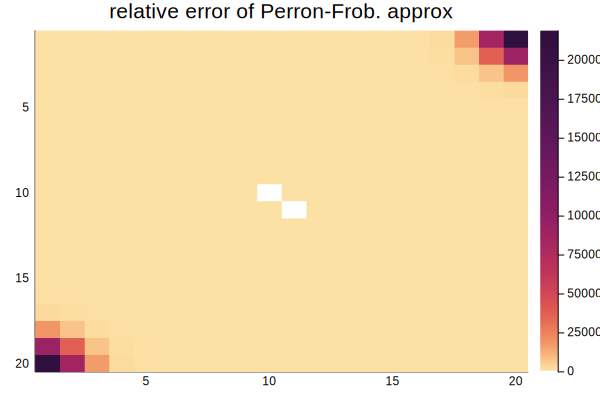

In [452]:
hm((Pf - Pf2) ./ Pf2, title="relative error of Perron-Frob. approx")

In [453]:
(Pf - Pf2)./Pf2

20×20 Array{Float64,2}:
    -0.876558       -0.837836    …      8.65166e10      2.19191e11
    -0.837966       -0.800171           3.72958e10      9.20198e10
    -0.615362       -0.593794           7.87299e9       1.87413e10
     0.0586871      -0.00410122         9.58631e8       2.1926e9  
     1.93958         1.52172            8.9835e7        1.9718e8  
     7.41831         5.67096     …      8.81439e6       1.85591e7 
    25.3786         18.4476             1.10387e6       2.22605e6 
    94.4929         64.7901             1.74722e5       3.36497e5 
   406.438         262.279          31537.9         57823.4       
  1988.09         1209.03            6037.85        10502.6       
 10502.6          6037.85        …   1209.03         1988.09      
 57823.4         31537.9              262.279         406.438     
     3.36497e5       1.74722e5         64.7901         94.4929    
     2.22605e6       1.10387e6         18.4476         25.3786    
     1.85591e7       8.81439e6        